# Code to find the massive merged progenitor and its path for a single Galaxy

Two methods are used to find the most massive progenitor

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sys
sys.path.insert(0,"../")
import illustris_python as il

In [2]:
from astropy.cosmology import FlatLambdaCDM

redshiftdata1=np.genfromtxt('data/redshift_TNG', dtype=[('snap','<i8'), ('redshift','<f8')])

def find_redshift(snap):
    if len(snap)==1:
        arg=np.where(redshiftdata1['snap']==snap)[0]
        if len(arg)>0:
            return redshiftdata1['redshift'][arg[0]]
    else:
        red=np.zeros_like(snap,dtype=float)
        for i in range(len(red)):
            arg=np.where(redshiftdata1['snap']==snap[i])[0]
            if len(arg)>0:
                red[i]=redshiftdata1['redshift'][arg[0]]
        return red
        
        
def redshift(scale):
    return 1.0/scale - 1.0

def find_scale(redshift):
    return 1.0/(redshift+1)

cosmo = FlatLambdaCDM(H0=67.74, Om0=0.3089)

def age(redshift):
    age1=cosmo.age(redshift)
    return 13.7 - age1.value

In [3]:
basePath = '/home/rdsouza/SIMS/TNG50/output/'
h0=0.6774

In [4]:
subhaloid=452978
tree1 = il.sublink.loadTree(basePath, 99, subhaloid)
dm_mw=tree1['SubhaloMassType'][0,1]

In [5]:
arg_mpb=np.where((tree1['SubhaloID'][:]>=tree1['SubhaloID'][0]) & (tree1['SubhaloID'][:]<=tree1['MainLeafProgenitorID'][0]))[0]
subhaloid_mpb          = tree1['SubhaloID'][arg_mpb]
subhaloid_mpb_snap     = tree1['SnapNum'][arg_mpb]
subhaloid_mpb_mass200  = tree1['Group_M_Crit200'][arg_mpb]*1e10 / h0
subhaloid_mpb_mass     = tree1['SubhaloMassType'][arg_mpb,4]*1e10 / h0
subhaloid_mpb_pos =tree1['SubhaloPos'][arg_mpb]
subhaloid_mpb_vel =tree1['SubhaloVel'][arg_mpb]

# convert everything to the refernce frame of the mpb.
for i in range(len(subhaloid_mpb_snap)):
    mask_snap=(tree1['SnapNum']==subhaloid_mpb_snap[i])
    tree1['SubhaloPos'][mask_snap]=tree1['SubhaloPos'][mask_snap]-subhaloid_mpb_pos[i]
    tree1['SubhaloVel'][mask_snap]=tree1['SubhaloVel'][mask_snap]-subhaloid_mpb_vel[i]
    
    


## Method 1

This is a modification of the original method found in Get_merger_trees-TNG-50.ipynb. This method was designed to trace subhaloes which fall into the FOFGroup, i.e., into the MW halo. It then followed these subhaloes to higher redshift tracing its mass. The hidden assumption here was that mass increase would occur before it fell into the main MW halo. I added an additional part which traces these subhaloes until they merge with the MPB.

In [6]:
subhaloid_mpb_firstsubhalo=tree1['FirstSubhaloInFOFGroupID'][arg_mpb]
mask_grp=np.in1d(tree1['FirstSubhaloInFOFGroupID'][:],subhaloid_mpb_firstsubhalo)
subhalosids_grp_in=tree1['SubhaloID'][mask_grp]
subhalosids_grp_out=tree1['SubhaloID'][~mask_grp]

# Find those that just fell in.
mask_just_fell_in= np.in1d(tree1['DescendantID'][~mask_grp],subhalosids_grp_in)
subhalosids_firstinfall=subhalosids_grp_out[mask_just_fell_in]
mask_first_infall=np.zeros_like(tree1['SubhaloID'][:],dtype=np.bool)
for j in range(len(subhalosids_firstinfall)):
    arg1=np.where(tree1['SubhaloID'][:]==subhalosids_firstinfall[j])[0]
    mask_first_infall[arg1]=True
    
    
# Apply a mass cut for the subhalos that fell in
mask_first_infall= mask_first_infall & ((tree1['SubhaloMassType'][:,1] * 1e10 / h0)>1e8)
arg1=np.where(mask_first_infall)[0]


# information about these subhalos which fell in
subhalosids_firstinfall=tree1['SubhaloID'][mask_first_infall]
snap_firstinfall=tree1['SnapNum'][mask_first_infall]
subhalosids_firstinfall_mpeak=np.zeros_like(subhalosids_firstinfall,dtype=float)
subhalosids_firstinfall_speak=np.zeros_like(subhalosids_firstinfall,dtype=float)
mask_subhalosids_firstinfall=np.ones_like(subhalosids_firstinfall,dtype=bool)


for j in range(len(arg1)):
    ii=arg1[j]
    arg_sub_mpb=np.where((tree1['SubhaloID'][:]>=tree1['SubhaloID'][ii]) & (tree1['SubhaloID'][:]<=tree1['MainLeafProgenitorID'][ii]))[0]  
    subhalosids_sub=tree1['SubhaloID'][arg_sub_mpb]
    subhalosids_firstinfall_mpeak[j] = np.max(tree1['SubhaloMassType'][arg_sub_mpb,1] * 1e10 / h0)
    subhalosids_firstinfall_speak[j] = np.max(tree1['SubhaloMassType'][arg_sub_mpb,4] * 1e10 / h0)
    if subhalosids_firstinfall_mpeak[j]/dm_mw<0.05:
        mask_subhalosids_firstinfall[j]=False
        continue
    mask_doublefall=np.in1d(subhalosids_firstinfall,subhalosids_sub)
    arg_check=np.where(subhalosids_firstinfall[mask_doublefall])[0]
    # one also finds oneself in the list.
    if len(arg_check)>1:
        arg_snap_check=np.where(snap_firstinfall[mask_doublefall]<  snap_firstinfall[j])[0]
        if len(arg_snap_check)>0: 
            mask_subhalosids_firstinfall[j]=False

subhalosids_firstinfall = subhalosids_firstinfall[mask_subhalosids_firstinfall]
subhalosids_firstinfall_mpeak=subhalosids_firstinfall_mpeak[mask_subhalosids_firstinfall]
subhalosids_firstinfall_speak=subhalosids_firstinfall_speak[mask_subhalosids_firstinfall]
snap_firstinfall=snap_firstinfall[mask_subhalosids_firstinfall]    


##### ADDITIONAL NEW PART BEGIN
# subhalo_id as it just falls into the group.
subhaloid_max = subhalosids_firstinfall[np.argmax(subhalosids_firstinfall_mpeak)]
# Trace this progenitor as it reaches the MPB
descendant_list=[]
while subhaloid_max not in subhaloid_mpb:
    arg1=np.where(tree1['SubhaloID'][:]==subhaloid_max)[0][0]
    descednentID=tree1['DescendantID'][arg1]
    descendant_list.append(descednentID)
    subhaloid_max=descednentID
subhaloid_max=descendant_list[-2]
##### ADDITIONAL NEW PART END


arg1=np.where(tree1['SubhaloID'][:]==subhaloid_max)[0][0]
arg_sub_mpb=np.where((tree1['SubhaloID'][:]>=tree1['SubhaloID'][arg1]) & (tree1['SubhaloID'][:]<=tree1['MainLeafProgenitorID'][arg1]))[0] 
subhalosids_sub=tree1['SubhaloID'][arg_sub_mpb]
subhalosids_mass=tree1['SubhaloMassType'][arg_sub_mpb,4] * 1e10 / h0
subhalosids_snap=tree1['SnapNum'][arg_sub_mpb] 
subhalosids_sub_pos = tree1['SubhaloPos'][arg_sub_mpb]
subhalosids_sub_scale=1/(1+find_redshift(subhalosids_snap))
subhalosids_sub_age=age(find_redshift(subhalosids_snap))
subhalosids_sub_dist=(np.sqrt(subhalosids_sub_pos[:,0]**2 + subhalosids_sub_pos[:,1]**2 + subhalosids_sub_pos[:,2]**2)*subhalosids_sub_scale/h0)

Text(0, 0.5, 'GalactocentricDistance (kpc)')

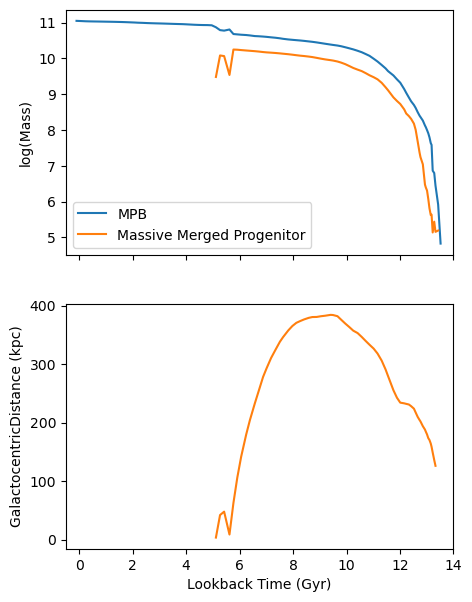

In [7]:
fig, (ax1, ax2) = plt.subplots(2,figsize=(5,7),sharex=True)


ax1.plot(age(find_redshift(subhaloid_mpb_snap)),np.log10(subhaloid_mpb_mass), label='MPB',color='C0')
ax1.plot(age(find_redshift(subhalosids_snap)),np.log10(subhalosids_mass), label='Massive Merged Progenitor',color='C1')
ax1.set_xlim([-0.5,14])
ax1.set_ylabel('log(Mass)')
ax1.legend()

ax2.plot(subhalosids_sub_age[:-1],subhalosids_sub_dist[:-1],color='C1')
ax2.set_xlim([-0.5,14])
ax2.set_xlabel('Lookback Time (Gyr)')
ax2.set_ylabel('GalactocentricDistance (kpc)')

## Method 2

This is a more direct approach to find the main subhalo which fell in. It queries all the Subhaloes not on the Main Progenitor Branch which merge with the main MW galaxy. It then traces these subhaloes to higher redshift and finds the most massive one. The disadvantage here is that we loose the information when it fell into the MW halo, though we could also easilly calculate that through post-processing.


In [8]:
arg_rest=np.where((tree1['SubhaloID'][:]>tree1['MainLeafProgenitorID'][0]))[0]
arg_fell_in=np.where(np.in1d(tree1['DescendantID'][arg_rest],tree1['SubhaloID'][arg_mpb]))[0]
mask_first_infall= np.in1d(np.where(tree1['SubhaloID'][:])[0],arg_fell_in)

In [9]:
# information about these subhalos which fell in
subhalosids_firstinfall=tree1['SubhaloID'][mask_first_infall]
snap_firstinfall=tree1['SnapNum'][mask_first_infall]
subhalosids_firstinfall_mpeak=np.zeros_like(subhalosids_firstinfall,dtype=float)
subhalosids_firstinfall_speak=np.zeros_like(subhalosids_firstinfall,dtype=float)
mask_subhalosids_firstinfall=np.ones_like(subhalosids_firstinfall,dtype=bool)


for j in range(len(arg_fell_in)):
    ii=arg_fell_in[j]
    arg_sub_mpb=np.where((tree1['SubhaloID'][:]>=tree1['SubhaloID'][ii]) & (tree1['SubhaloID'][:]<=tree1['MainLeafProgenitorID'][ii]))[0]  
    subhalosids_sub=tree1['SubhaloID'][arg_sub_mpb]
    subhalosids_firstinfall_mpeak[j] = np.max(tree1['SubhaloMassType'][arg_sub_mpb,1] * 1e10 / h0)
    subhalosids_firstinfall_speak[j] = np.max(tree1['SubhaloMassType'][arg_sub_mpb,4] * 1e10 / h0)
    if subhalosids_firstinfall_mpeak[j]/dm_mw<0.05:
        mask_subhalosids_firstinfall[j]=False
        continue
    mask_doublefall=np.in1d(subhalosids_firstinfall,subhalosids_sub)
    arg_check=np.where(subhalosids_firstinfall[mask_doublefall])[0]
    # one also finds oneself in the list.
    if len(arg_check)>1:
        arg_snap_check=np.where(snap_firstinfall[mask_doublefall]<  snap_firstinfall[j])[0]
        if len(arg_snap_check)>0: 
            mask_subhalosids_firstinfall[j]=False

subhalosids_firstinfall = subhalosids_firstinfall[mask_subhalosids_firstinfall]
subhalosids_firstinfall_mpeak=subhalosids_firstinfall_mpeak[mask_subhalosids_firstinfall]
subhalosids_firstinfall_speak=subhalosids_firstinfall_speak[mask_subhalosids_firstinfall]
snap_firstinfall=snap_firstinfall[mask_subhalosids_firstinfall]    


arg1=np.where(tree1['SubhaloID'][:]==subhaloid_max)[0][0]
arg_sub_mpb=np.where((tree1['SubhaloID'][:]>=tree1['SubhaloID'][arg1]) & (tree1['SubhaloID'][:]<=tree1['MainLeafProgenitorID'][arg1]))[0] 
subhalosids_sub=tree1['SubhaloID'][arg_sub_mpb]
subhalosids_mass=tree1['SubhaloMassType'][arg_sub_mpb,4] * 1e10 / h0
subhalosids_snap=tree1['SnapNum'][arg_sub_mpb] 
subhalosids_sub_pos = tree1['SubhaloPos'][arg_sub_mpb]
subhalosids_sub_scale=1/(1+find_redshift(subhalosids_snap))
subhalosids_sub_age=age(find_redshift(subhalosids_snap))
subhalosids_sub_dist=(np.sqrt(subhalosids_sub_pos[:,0]**2 + subhalosids_sub_pos[:,1]**2 + subhalosids_sub_pos[:,2]**2)*subhalosids_sub_scale/h0)

Text(0, 0.5, 'GalactocentricDistance (kpc)')

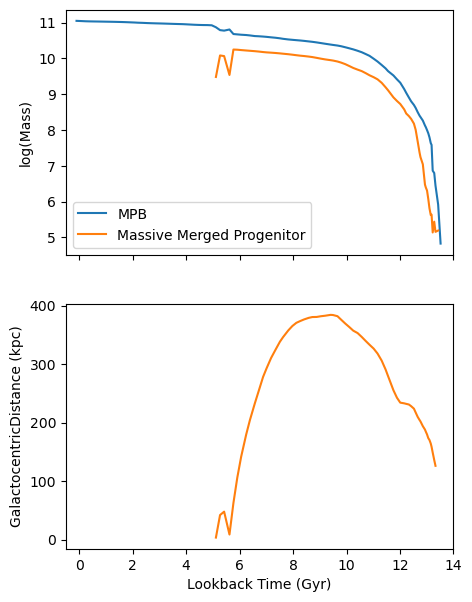

In [10]:
fig, (ax1, ax2) = plt.subplots(2,figsize=(5,7),sharex=True)


ax1.plot(age(find_redshift(subhaloid_mpb_snap)),np.log10(subhaloid_mpb_mass), label='MPB',color='C0')
ax1.plot(age(find_redshift(subhalosids_snap)),np.log10(subhalosids_mass), label='Massive Merged Progenitor',color='C1')
ax1.set_xlim([-0.5,14])
ax1.set_ylabel('log(Mass)')
ax1.legend()

ax2.plot(subhalosids_sub_age[:-1],subhalosids_sub_dist[:-1],color='C1')
ax2.set_xlim([-0.5,14])
ax2.set_xlabel('Lookback Time (Gyr)')
ax2.set_ylabel('GalactocentricDistance (kpc)')